# Load Data
We will load all the data except 219 V columns that were determined redundant by correlation analysis

In [38]:
import numpy as np, pandas as pd, os, gc
from sklearn.model_selection import GroupKFold
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# COLUMNS WITH STRINGS
str_type = ['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain','M1', 'M2', 'M3', 'M4','M5',
            'M6', 'M7', 'M8', 'M9', 'id_12', 'id_15', 'id_16', 'id_23', 'id_27', 'id_28', 'id_29', 'id_30', 
            'id_31', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo']
str_type += ['id-12', 'id-15', 'id-16', 'id-23', 'id-27', 'id-28', 'id-29', 'id-30', 
            'id-31', 'id-33', 'id-34', 'id-35', 'id-36', 'id-37', 'id-38']

# FIRST 53 COLUMNS
cols = ['TransactionID', 'TransactionDT', 'TransactionAmt',
       'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6',
       'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain', 'R_emaildomain',
       'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11',
       'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8',
       'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'M1', 'M2', 'M3', 'M4',
       'M5', 'M6', 'M7', 'M8', 'M9']

# V COLUMNS TO LOAD DECIDED BY CORRELATION EDA
# https://www.kaggle.com/cdeotte/eda-for-columns-v-and-id
v =  [1, 3, 4, 6, 8, 11]
v += [13, 14, 17, 20, 23, 26, 27, 30]
v += [36, 37, 40, 41, 44, 47, 48]
v += [54, 56, 59, 62, 65, 67, 68, 70]
v += [76, 78, 80, 82, 86, 88, 89, 91]

#v += [96, 98, 99, 104] #relates to groups, no NAN 
v += [107, 108, 111, 115, 117, 120, 121, 123] # maybe group, no NAN
v += [124, 127, 129, 130, 136] # relates to groups, no NAN

# LOTS OF NAN BELOW
v += [138, 139, 142, 147, 156, 162] #b1
v += [165, 160, 166] #b1
v += [178, 176, 173, 182] #b2
v += [187, 203, 205, 207, 215] #b2
v += [169, 171, 175, 180, 185, 188, 198, 210, 209] #b2
v += [218, 223, 224, 226, 228, 229, 235] #b3
v += [240, 258, 257, 253, 252, 260, 261] #b3
v += [264, 266, 267, 274, 277] #b3
v += [220, 221, 234, 238, 250, 271] #b3

v += [294, 284, 285, 286, 291, 297] # relates to grous, no NAN
v += [303, 305, 307, 309, 310, 320] # relates to groups, no NAN
v += [281, 283, 289, 296, 301, 314] # relates to groups, no NAN
#v += [332, 325, 335, 338] # b4 lots NAN

cols += ['V'+str(x) for x in v]
dtypes = {}
for c in cols+['id_0'+str(x) for x in range(1,10)]+['id_'+str(x) for x in range(10,34)]+\
    ['id-0'+str(x) for x in range(1,10)]+['id-'+str(x) for x in range(10,34)]:
        dtypes[c] = 'float32'
for c in str_type: dtypes[c] = 'category'

In [39]:
%%time
# LOAD TRAIN
X_train = pd.read_csv('../input/ieee-fraud-detection/train_transaction.csv',index_col='TransactionID', dtype=dtypes, usecols=cols+['isFraud'])
train_id = pd.read_csv('../input/ieee-fraud-detection/train_identity.csv',index_col='TransactionID', dtype=dtypes)
X_train = X_train.merge(train_id, how='left', left_index=True, right_index=True)
# LOAD TEST
X_test = pd.read_csv('../input/ieee-fraud-detection/test_transaction.csv',index_col='TransactionID', dtype=dtypes, usecols=cols)
test_id = pd.read_csv('../input/ieee-fraud-detection/test_identity.csv',index_col='TransactionID', dtype=dtypes)
fix = {o:n for o, n in zip(test_id.columns, train_id.columns)}
test_id.rename(columns=fix, inplace=True)
X_test = X_test.merge(test_id, how='left', left_index=True, right_index=True)
# TARGET
y_train = X_train['isFraud'].copy()
del train_id, test_id, X_train['isFraud']; x = gc.collect()
# PRINT STATUS
print('Train shape',X_train.shape,'test shape',X_test.shape)

Train shape (590540, 213) test shape (506691, 213)
CPU times: user 28.4 s, sys: 1.2 s, total: 29.6 s
Wall time: 29.6 s


# Normalize D Columns
The D Columns are "time deltas" from some point in the past. We will transform the D Columns into their point in the past. This will stop the D columns from increasing with time. The formula is `D15n = Transaction_Day - D15` and `Transaction_Day = TransactionDT/(24*60*60)`. Afterward we multiple this number by negative one.

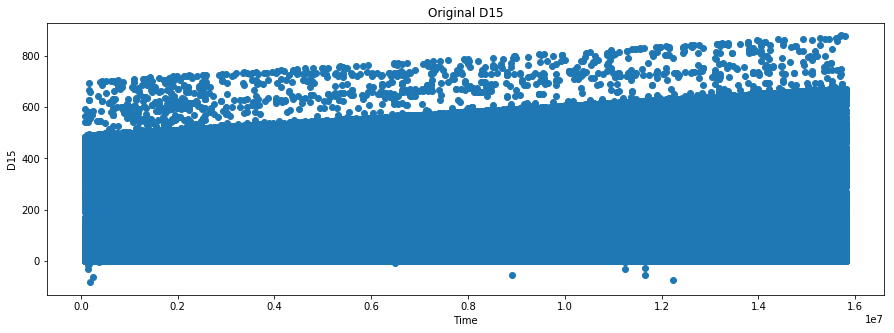

In [40]:
# PLOT ORIGINAL D
plt.figure(figsize=(15,5))
plt.scatter(X_train.TransactionDT,X_train.D15)
plt.title('Original D15')
plt.xlabel('Time')
plt.ylabel('D15')
plt.show()

In [41]:
# NORMALIZE D COLUMNS
for i in range(1,16):
    if i in [1,2,3,5,9]: continue
    X_train['D'+str(i)] =  X_train['D'+str(i)] - X_train.TransactionDT/np.float32(24*60*60)
    X_test['D'+str(i)] = X_test['D'+str(i)] - X_test.TransactionDT/np.float32(24*60*60) 

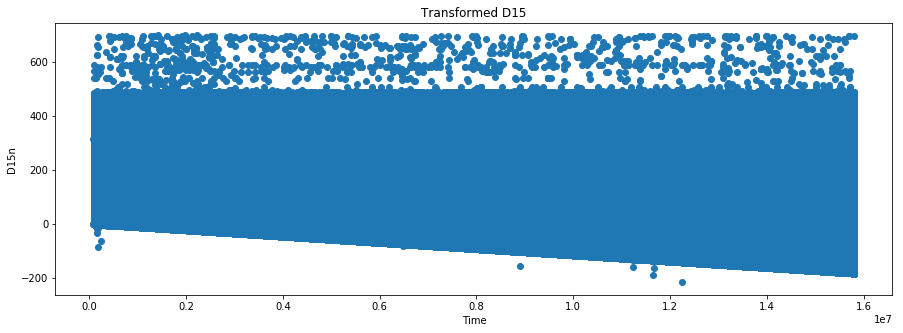

In [42]:
# PLOT TRANSFORMED D
plt.figure(figsize=(15,5))
plt.scatter(X_train.TransactionDT,X_train.D15)
plt.title('Transformed D15')
plt.xlabel('Time')
plt.ylabel('D15n')
plt.show()

In [43]:
%%time
# LABEL ENCODE AND MEMORY REDUCE
for i,f in enumerate(X_train.columns):
    # FACTORIZE CATEGORICAL VARIABLES
    if (np.str(X_train[f].dtype)=='category')|(X_train[f].dtype=='object'): 
        df_comb = pd.concat([X_train[f],X_test[f]],axis=0)
        df_comb,_ = df_comb.factorize(sort=True)
        if df_comb.max()>32000: print(f,'needs int32')
        X_train[f] = df_comb[:len(X_train)].astype('int16')
        X_test[f] = df_comb[len(X_train):].astype('int16')
    # SHIFT ALL NUMERICS POSITIVE. SET NAN to -1
    elif f not in ['TransactionAmt','TransactionDT']:
        mn = np.min((X_train[f].min(),X_test[f].min()))
        X_train[f] -= np.float32(mn)
        X_test[f] -= np.float32(mn)
        X_train[f].fillna(-1,inplace=True)
        X_test[f].fillna(-1,inplace=True)

CPU times: user 3.06 s, sys: 25.9 ms, total: 3.08 s
Wall time: 2.96 s


# Encoding Functions
Below are 5 encoding functions. (1) `encode_FE` does frequency encoding where it combines train and test first and then encodes. (2) `encode_LE` is a label encoded for categorical features (3) `encode_AG` makes aggregated features such as aggregated mean and std (4) `encode_CB` combines two columns (5) `encode_AG2` makes aggregated features where it counts how many unique values of one feature is within a group.

In [44]:
# FREQUENCY ENCODE TOGETHER
def encode_FE(df1, df2, cols):
    for col in cols:
        df = pd.concat([df1[col],df2[col]])
        vc = df.value_counts(dropna=True, normalize=True).to_dict()
        vc[-1] = -1
        nm = col+'_FE'
        df1[nm] = df1[col].map(vc)
        df1[nm] = df1[nm].astype('float32')
        df2[nm] = df2[col].map(vc)
        df2[nm] = df2[nm].astype('float32')
        print(nm,', ',end='')
        
# LABEL ENCODE
def encode_LE(col,train=X_train,test=X_test,verbose=True):
    df_comb = pd.concat([train[col],test[col]],axis=0)
    df_comb,_ = df_comb.factorize(sort=True)
    nm = col
    if df_comb.max()>32000: 
        train[nm] = df_comb[:len(train)].astype('int32')
        test[nm] = df_comb[len(train):].astype('int32')
    else:
        train[nm] = df_comb[:len(train)].astype('int16')
        test[nm] = df_comb[len(train):].astype('int16')
    del df_comb; x=gc.collect()
    if verbose: print(nm,', ',end='')
        
# GROUP AGGREGATION MEAN AND STD
# https://www.kaggle.com/kyakovlev/ieee-fe-with-some-eda
def encode_AG(main_columns, uids, aggregations=['mean'], train_df=X_train, test_df=X_test, 
              fillna=True, usena=False):
    # AGGREGATION OF MAIN WITH UID FOR GIVEN STATISTICS
    for main_column in main_columns:  
        for col in uids:
            for agg_type in aggregations:
                new_col_name = main_column+'_'+col+'_'+agg_type
                temp_df = pd.concat([train_df[[col, main_column]], test_df[[col,main_column]]])
                if usena: temp_df.loc[temp_df[main_column]==-1,main_column] = np.nan
                temp_df = temp_df.groupby([col])[main_column].agg([agg_type]).reset_index().rename(
                                                        columns={agg_type: new_col_name})

                temp_df.index = list(temp_df[col])
                temp_df = temp_df[new_col_name].to_dict()   

                train_df[new_col_name] = train_df[col].map(temp_df).astype('float32')
                test_df[new_col_name]  = test_df[col].map(temp_df).astype('float32')
                
                if fillna:
                    train_df[new_col_name].fillna(-1,inplace=True)
                    test_df[new_col_name].fillna(-1,inplace=True)
                
                print("'"+new_col_name+"'",', ',end='')
                
# COMBINE FEATURES
def encode_CB(col1,col2,df1=X_train,df2=X_test):
    nm = col1+'_'+col2
    df1[nm] = df1[col1].astype(str)+'_'+df1[col2].astype(str)
    df2[nm] = df2[col1].astype(str)+'_'+df2[col2].astype(str) 
    encode_LE(nm,verbose=False)
    print(nm,', ',end='')
    
# GROUP AGGREGATION NUNIQUE
def encode_AG2(main_columns, uids, train_df=X_train, test_df=X_test):
    for main_column in main_columns:  
        for col in uids:
            comb = pd.concat([train_df[[col]+[main_column]],test_df[[col]+[main_column]]],axis=0)
            mp = comb.groupby(col)[main_column].agg(['nunique'])['nunique'].to_dict()
            train_df[col+'_'+main_column+'_ct'] = train_df[col].map(mp).astype('float32')
            test_df[col+'_'+main_column+'_ct'] = test_df[col].map(mp).astype('float32')
            print(col+'_'+main_column+'_ct, ',end='')

# Feature engineering

In [45]:
# TRANSACTION AMT CENTS
X_train['cents'] = (X_train['TransactionAmt'] - np.floor(X_train['TransactionAmt'])).astype('float32')
X_test['cents'] = (X_test['TransactionAmt'] - np.floor(X_test['TransactionAmt'])).astype('float32')
print('cents, ', end='')
# FREQUENCY ENCODE: ADDR1, CARD1, CARD2, CARD3, P_EMAILDOMAIN
encode_FE(X_train,X_test,['addr1','card1','card2','card3','P_emaildomain'])
# COMBINE COLUMNS CARD1+ADDR1, CARD1+ADDR1+P_EMAILDOMAIN
encode_CB('card1','addr1')
encode_CB('card1_addr1','P_emaildomain')
# FREQUENCY ENOCDE
encode_FE(X_train,X_test,['card1_addr1','card1_addr1_P_emaildomain'])
# GROUP AGGREGATE
encode_AG(['TransactionAmt','D9','D11'],['card1','card1_addr1','card1_addr1_P_emaildomain'],['mean','std'],usena=True)

cents, addr1_FE , card1_FE , card2_FE , card3_FE , P_emaildomain_FE , card1_addr1 , card1_addr1_P_emaildomain , card1_addr1_FE , card1_addr1_P_emaildomain_FE , 'TransactionAmt_card1_mean' , 'TransactionAmt_card1_std' , 'TransactionAmt_card1_addr1_mean' , 'TransactionAmt_card1_addr1_std' , 'TransactionAmt_card1_addr1_P_emaildomain_mean' , 'TransactionAmt_card1_addr1_P_emaildomain_std' , 'D9_card1_mean' , 'D9_card1_std' , 'D9_card1_addr1_mean' , 'D9_card1_addr1_std' , 'D9_card1_addr1_P_emaildomain_mean' , 'D9_card1_addr1_P_emaildomain_std' , 'D11_card1_mean' , 'D11_card1_std' , 'D11_card1_addr1_mean' , 'D11_card1_addr1_std' , 'D11_card1_addr1_P_emaildomain_mean' , 'D11_card1_addr1_P_emaildomain_std' , 

# Feature Selection - Time Consistency

We added 28 new feature above. We have already removed 219 V Columns from correlation analysis. So we currently have 242 features now. We will now check each of our 242 for "time consistency". We will build 242 models. Each model will be trained on the first month of the training data and will only use one feature. We will then predict the last month of the training data. We want both training AUC and validation AUC to be above AUC = 0.5. It turns out that 19 features fail this test so we will remove them. Additionally we will remove 7 D columns that are mostly NAN. More techniques for feature selection are listed here

In [46]:
cols = list( X_train.columns )
cols.remove('TransactionDT')
for c in ['D6','D7','D8','D9','D12','D13','D14']:
    cols.remove(c)
    
# FAILED TIME CONSISTENCY TEST
for c in ['C3','M5','id_08','id_33']:
    cols.remove(c)
for c in ['card4','id_07','id_14','id_21','id_30','id_32','id_34']:
    cols.remove(c)
for c in ['id_'+str(x) for x in range(22,28)]:
    cols.remove(c)

In [47]:
print('NOW USING THE FOLLOWING',len(cols),'FEATURES.')
np.array(cols)

NOW USING THE FOLLOWING 216 FEATURES.


array(['TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card5',
       'card6', 'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain',
       'R_emaildomain', 'C1', 'C2', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9',
       'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5',
       'D10', 'D11', 'D15', 'M1', 'M2', 'M3', 'M4', 'M6', 'M7', 'M8',
       'M9', 'V1', 'V3', 'V4', 'V6', 'V8', 'V11', 'V13', 'V14', 'V17',
       'V20', 'V23', 'V26', 'V27', 'V30', 'V36', 'V37', 'V40', 'V41',
       'V44', 'V47', 'V48', 'V54', 'V56', 'V59', 'V62', 'V65', 'V67',
       'V68', 'V70', 'V76', 'V78', 'V80', 'V82', 'V86', 'V88', 'V89',
       'V91', 'V107', 'V108', 'V111', 'V115', 'V117', 'V120', 'V121',
       'V123', 'V124', 'V127', 'V129', 'V130', 'V136', 'V138', 'V139',
       'V142', 'V147', 'V156', 'V160', 'V162', 'V165', 'V166', 'V169',
       'V171', 'V173', 'V175', 'V176', 'V178', 'V180', 'V182', 'V185',
       'V187', 'V188', 'V198', 'V203', 'V205', 'V207', 'V209', 'V210',
       '

# Feature Engineering - UID
We create a UID which will help our model find clients (credit cards). This UID isn't perfect. Many UID values contain 2 or more clients inside. However our model will detect this and by adding more splits with its trees, it will split these UIDs and find the single clients (credit cards).

In [48]:
X_train['day'] = X_train.TransactionDT / (24*60*60)
X_train['uid'] = X_train.card1_addr1.astype(str)+'_'+np.floor(X_train.day-X_train.D1).astype(str)

X_test['day'] = X_test.TransactionDT / (24*60*60)
X_test['uid'] = X_test.card1_addr1.astype(str)+'_'+np.floor(X_test.day-X_test.D1).astype(str)

In [49]:
import datetime
START_DATE = datetime.datetime.strptime('2017-11-30', '%Y-%m-%d')
X_train['DT_M'] = X_train['TransactionDT'].apply(lambda x: (START_DATE + datetime.timedelta(seconds = x)))
X_train['DT_M'] = (X_train['DT_M'].dt.year-2017)*12 + X_train['DT_M'].dt.month 

X_test['DT_M'] = X_test['TransactionDT'].apply(lambda x: (START_DATE + datetime.timedelta(seconds = x)))
X_test['DT_M'] = (X_test['DT_M'].dt.year-2017)*12 + X_test['DT_M'].dt.month

# Group Aggregation Features
For our model to use the new UID, we need to make lots of aggregated group features. We will add 47 new features! The intuition behind this in the report explains why this works. Note that after aggregation, we remove UID from our model. We don't use UID directly.

In [50]:
%%time
# FREQUENCY ENCODE UID
encode_FE(X_train,X_test,['uid'])
# AGGREGATE 
encode_AG(['TransactionAmt','D4','D9','D10','D15'],['uid'],['mean','std'],fillna=True,usena=True)
# AGGREGATE
encode_AG(['C'+str(x) for x in range(1,15) if x!=3],['uid'],['mean'],X_train,X_test,fillna=True,usena=True)
# AGGREGATE
encode_AG(['M'+str(x) for x in range(1,10)],['uid'],['mean'],fillna=True,usena=True)
# AGGREGATE
encode_AG2(['P_emaildomain','dist1','DT_M','id_02','cents'], ['uid'], train_df=X_train, test_df=X_test)
# AGGREGATE
encode_AG(['C14'],['uid'],['std'],X_train,X_test,fillna=True,usena=True)
# AGGREGATE 
encode_AG2(['C13','V314'], ['uid'], train_df=X_train, test_df=X_test)
# AGGREATE 
encode_AG2(['V127','V136','V309','V307','V320'], ['uid'], train_df=X_train, test_df=X_test)
# NEW FEATURE
X_train['outsider15'] = (np.abs(X_train.D1-X_train.D15)>3).astype('int8')
X_test['outsider15'] = (np.abs(X_test.D1-X_test.D15)>3).astype('int8')
print('outsider15')

uid_FE , 'TransactionAmt_uid_mean' , 'TransactionAmt_uid_std' , 'D4_uid_mean' , 'D4_uid_std' , 'D9_uid_mean' , 'D9_uid_std' , 'D10_uid_mean' , 'D10_uid_std' , 'D15_uid_mean' , 'D15_uid_std' , 'C1_uid_mean' , 'C2_uid_mean' , 'C4_uid_mean' , 'C5_uid_mean' , 'C6_uid_mean' , 'C7_uid_mean' , 'C8_uid_mean' , 'C9_uid_mean' , 'C10_uid_mean' , 'C11_uid_mean' , 'C12_uid_mean' , 'C13_uid_mean' , 'C14_uid_mean' , 'M1_uid_mean' , 'M2_uid_mean' , 'M3_uid_mean' , 'M4_uid_mean' , 'M5_uid_mean' , 'M6_uid_mean' , 'M7_uid_mean' , 'M8_uid_mean' , 'M9_uid_mean' , uid_P_emaildomain_ct, uid_dist1_ct, uid_DT_M_ct, uid_id_02_ct, uid_cents_ct, 'C14_uid_std' , uid_C13_ct, uid_V314_ct, uid_V127_ct, uid_V136_ct, uid_V309_ct, uid_V307_ct, uid_V320_ct, outsider15
CPU times: user 2min 38s, sys: 47.6 s, total: 3min 26s
Wall time: 3min 26s


In [51]:
print('NOW USING THE FOLLOWING',len(cols),'FEATURES.')
np.array(cols)

NOW USING THE FOLLOWING 216 FEATURES.


array(['TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card5',
       'card6', 'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain',
       'R_emaildomain', 'C1', 'C2', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9',
       'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5',
       'D10', 'D11', 'D15', 'M1', 'M2', 'M3', 'M4', 'M6', 'M7', 'M8',
       'M9', 'V1', 'V3', 'V4', 'V6', 'V8', 'V11', 'V13', 'V14', 'V17',
       'V20', 'V23', 'V26', 'V27', 'V30', 'V36', 'V37', 'V40', 'V41',
       'V44', 'V47', 'V48', 'V54', 'V56', 'V59', 'V62', 'V65', 'V67',
       'V68', 'V70', 'V76', 'V78', 'V80', 'V82', 'V86', 'V88', 'V89',
       'V91', 'V107', 'V108', 'V111', 'V115', 'V117', 'V120', 'V121',
       'V123', 'V124', 'V127', 'V129', 'V130', 'V136', 'V138', 'V139',
       'V142', 'V147', 'V156', 'V160', 'V162', 'V165', 'V166', 'V169',
       'V171', 'V173', 'V175', 'V176', 'V178', 'V180', 'V182', 'V185',
       'V187', 'V188', 'V198', 'V203', 'V205', 'V207', 'V209', 'V210',
       '

# Local Validation

In [52]:
import xgboost as xgb

# TRAIN 75% PREDICT 25%
idxT = X_train.index[:3*len(X_train)//4]
idxV = X_train.index[3*len(X_train)//4:]

In [53]:
clf = xgb.XGBClassifier( 
        n_estimators=2000,
        max_depth=12, 
        learning_rate=0.02, 
        subsample=0.8,
        colsample_bytree=0.4, 
        missing=-1, 
        eval_metric='auc',
        #nthread=4,
        #tree_method='hist' 
        tree_method='gpu_hist' 
    )
h = clf.fit(X_train.loc[idxT,cols], y_train[idxT], 
    eval_set=[(X_train.loc[idxV,cols],y_train[idxV])],
    verbose=50, early_stopping_rounds=100)

[0]	validation_0-auc:0.787465
Will train until validation_0-auc hasn't improved in 100 rounds.
[50]	validation_0-auc:0.87831
[100]	validation_0-auc:0.894946
[150]	validation_0-auc:0.908081
[200]	validation_0-auc:0.919298
[250]	validation_0-auc:0.926025
[300]	validation_0-auc:0.930295
[350]	validation_0-auc:0.933587
[400]	validation_0-auc:0.934809
[450]	validation_0-auc:0.935666
[500]	validation_0-auc:0.936271
[550]	validation_0-auc:0.93604
[600]	validation_0-auc:0.936234
Stopping. Best iteration:
[508]	validation_0-auc:0.936293



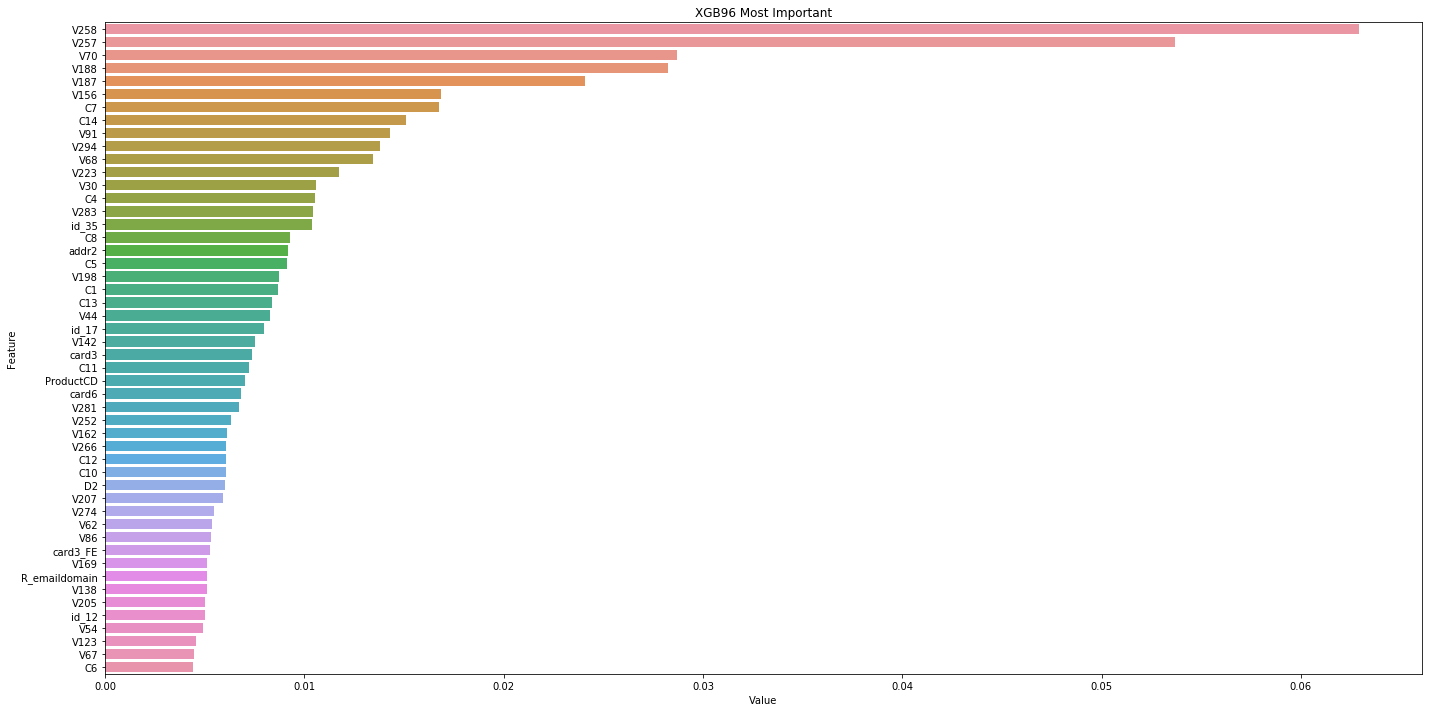

In [54]:
feature_imp = pd.DataFrame(sorted(zip(clf.feature_importances_,cols)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).iloc[:50])
plt.title('XGB96 Most Important')
plt.tight_layout()
plt.show()
        
del clf, h; x=gc.collect()

# Predict test.csv

In [55]:
oof = np.zeros(len(X_train))
preds = np.zeros(len(X_test))

skf = GroupKFold(n_splits=6)
for i, (idxT, idxV) in enumerate( skf.split(X_train, y_train, groups=X_train['DT_M']) ):
    month = X_train.iloc[idxV]['DT_M'].iloc[0]
    print('Fold',i,'withholding month',month)
    print(' rows of train =',len(idxT),'rows of holdout =',len(idxV))
    clf = xgb.XGBClassifier(
        n_estimators=5000,
        max_depth=12,
        learning_rate=0.02,
        subsample=0.8,
        colsample_bytree=0.4,
        missing=-1,
        eval_metric='auc',
        # USE CPU
        #nthread=4,
        #tree_method='hist'
        # USE GPU
        tree_method='gpu_hist' 
    )        
    h = clf.fit(X_train[cols].iloc[idxT], y_train.iloc[idxT], 
            eval_set=[(X_train[cols].iloc[idxV],y_train.iloc[idxV])],
            verbose=100, early_stopping_rounds=200)
    
    oof[idxV] += clf.predict_proba(X_train[cols].iloc[idxV])[:,1]
    preds += clf.predict_proba(X_test[cols])[:,1]/skf.n_splits
    del h, clf
    x=gc.collect()
print('#'*20)
print ('XGB96 OOF CV=',roc_auc_score(y_train,oof))

Fold 0 withholding month 12
 rows of train = 453219 rows of holdout = 137321
[0]	validation_0-auc:0.757194
Will train until validation_0-auc hasn't improved in 200 rounds.
[100]	validation_0-auc:0.871341
[200]	validation_0-auc:0.892256
[300]	validation_0-auc:0.903352
[400]	validation_0-auc:0.907912
[500]	validation_0-auc:0.908055
[600]	validation_0-auc:0.907959
Stopping. Best iteration:
[417]	validation_0-auc:0.908466

Fold 1 withholding month 15
 rows of train = 488908 rows of holdout = 101632
[0]	validation_0-auc:0.832247
Will train until validation_0-auc hasn't improved in 200 rounds.
[100]	validation_0-auc:0.906459
[200]	validation_0-auc:0.929275
[300]	validation_0-auc:0.940543
[400]	validation_0-auc:0.944592
[500]	validation_0-auc:0.946015
[600]	validation_0-auc:0.94661
[700]	validation_0-auc:0.946441
[800]	validation_0-auc:0.946432
Stopping. Best iteration:
[601]	validation_0-auc:0.946614

Fold 2 withholding month 13
 rows of train = 497955 rows of holdout = 92585
[0]	validation_

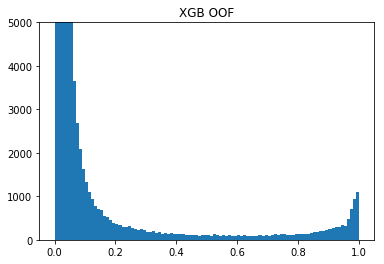

In [56]:
plt.hist(oof,bins=100)
plt.ylim((0,5000))
plt.title('XGB OOF')
plt.show()

X_train['oof'] = oof
X_train.reset_index(inplace=True)
X_train[['TransactionID','oof']].to_csv('oof_xgb_96.csv')
X_train.set_index('TransactionID',drop=True,inplace=True)

# Kaggle Submission

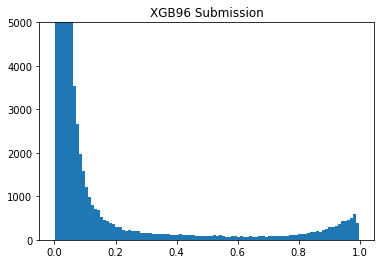

In [57]:
sample_submission = pd.read_csv('../input/ieee-fraud-detection/sample_submission.csv')
sample_submission.isFraud = preds
sample_submission.to_csv('sub_xgb_96.csv',index=False)

plt.hist(sample_submission.isFraud,bins=100)
plt.ylim((0,5000))
plt.title('XGB96 Submission')
plt.show()